In [1]:
import os
import torch
from mei.methods import gradient_ascent
from mei.modules import ConstrainedOutputModel
import urllib
import datajoint as dj

import matplotlib.pyplot as plt
from nnfabrik.builder import get_model


/Users/m_vys/Documents/mei/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# only need to run once at the beginning
!pip3 install git+https://github.com/sinzlab/nnvision.git@model_builder

  Cloning https://github.com/sinzlab/nnvision.git (to revision model_builder) to /private/var/folders/b6/pdfw16rd28scv557pv29qm600000gq/T/pip-req-build-av8af7xt
  Running command git clone --filter=blob:none --quiet https://github.com/sinzlab/nnvision.git /private/var/folders/b6/pdfw16rd28scv557pv29qm600000gq/T/pip-req-build-av8af7xt
  Running command git checkout -b model_builder --track origin/model_builder
  Switched to a new branch 'model_builder'
  branch 'model_builder' set up to track 'origin/model_builder'.
  Resolved https://github.com/sinzlab/nnvision.git to commit 8218786fa1ef313ead3068af74f09c803701a06b
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/KonstantinWilleke/neuralpredictors.git (to revision transformer_readout) to /private/var/folders/b6/pdfw16rd28scv557pv29qm600000gq/T/pip-install-3cuskvnx/neuralpredictors_ee617e30188a4822a262068deeaad479
  Running command git clone --filter=blob:none --quiet https://github.com/KonstantinWilleke/neuralpredi

### Download model file
We download an example model trained on mouse V1 neurons as a baseline for the [Sensorium 2022 competition](https://github.com/sinzlab/sensorium)

In [18]:
url = 'https://github.com/sinzlab/nnvision/raw/model_builder/nnvision/data/model_weights/v4_task_driven/task_driven_ensemble_model_01.pth.tar'
filepath = './pretrained_models/task_driven_ensemble_model_01.pth.tar'
urllib.request.urlretrieve(url, filepath)


('./pretrained_models/task_driven_ensemble_model_01.pth.tar',
 <http.client.HTTPMessage at 0x2ad84c190>)

In [4]:
# some hackity hack to be ignored
dj.config["database.host"] = "{host_address}"
dj.config["database.user"] = "{user}"
dj.config["database.password"] = "{password}"

In [21]:
# method loading example model
def get_v4_model():
    model_fn = 'nnvision.models.ptrmodels.task_core_gauss_readout'
    model_config =  {'input_channels': 1,
      'model_name': 'resnet50_l2_eps0_1',
      'layer_name': 'layer3.0',
      'pretrained': False,
      'bias': False,
      'final_batchnorm': True,
      'final_nonlinearity': True,
      'momentum': 0.1,
      'fine_tune': False,
      'init_mu_range': 0.4,
      'init_sigma_range': 0.6,
      'readout_bias': True,
      'gamma_readout': 3.0,
      'gauss_type': 'isotropic',
      'elu_offset': -1,
                     }
    
    data_info = {
        "all_sessions": {
            "input_dimensions": torch.Size([64, 1, 100, 100]),
            "input_channels": 1,
            "output_dimension": 1244,
            "img_mean": 124.54466,
            "img_std": 70.28,
        },
    }
    
    filename = os.path.join('./pretrained_models/task_driven_ensemble_model_01.pth.tar')
    state_dict = torch.load(filename, map_location='cpu')
    
    v4_data_task_sota = get_model(
        model_fn, model_config, seed=10, data_info=data_info, state_dict=state_dict,
    )
    
    return v4_data_task_sota, data_info



# Load the model


In [22]:
model, data_info = get_v4_model()


/Users/m_vys/Documents/mei/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/m_vys/Documents/mei/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Create single cell model
Here you select the index of the cell for which you'd like to optimize the MEI

In [24]:
cell_index = 403

In [25]:
single_cell_model = ConstrainedOutputModel(model, cell_index)

# Configurations
Configurations for the MEI optimization algorithm

In [26]:
seed = 8
# learning rate
lr = 1

# number of iterations for which the MEI is optimized
num_iterations = 1000 

 # interval with which the objective will be evaluated
interval = 10

# shape of the MEI
input_shape = (1,) + data_info["all_sessions"]['input_dimensions'][1:] 
device='cpu'

In [27]:
method_config = dict(
    initial=dict(path="mei.initial.RandomNormal"),
    optimizer=dict(path="torch.optim.SGD", kwargs=dict(lr=lr)),
    stopper=dict(path="mei.stoppers.NumIterations", kwargs=dict(num_iterations=num_iterations)),
    objectives=[dict(path="mei.objectives.EvaluationObjective", kwargs=dict(interval=interval))],
    device=device,
)

# Optimize MEI

In [30]:
mei, final_evaluation, tracker_log = gradient_ascent(model=single_cell_model, config=method_config, seed=seed, shape=input_shape)   

initial {'path': 'mei.initial.RandomNormal'}
optimizer {'path': 'torch.optim.SGD', 'kwargs': {'lr': 1}}
stopper {'path': 'mei.stoppers.NumIterations', 'kwargs': {'num_iterations': 1000}}
objectives [{'path': 'mei.objectives.EvaluationObjective', 'kwargs': {'interval': 10}}]
device cpu


# Visualize MEI

torch.Size([1, 1, 100, 100])
tensor(38.1945)


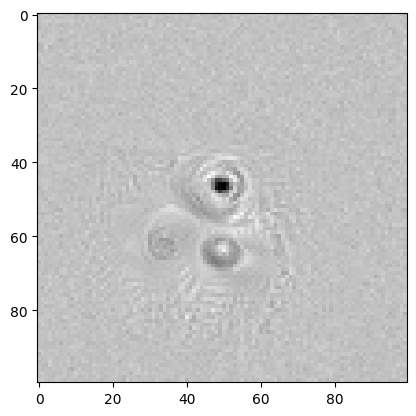

In [31]:
print(mei.shape)
print(torch.max(torch.abs(mei)))
plt.imshow(mei[0,0], cmap='gray')

Text(0, 0.5, 'evaluation')

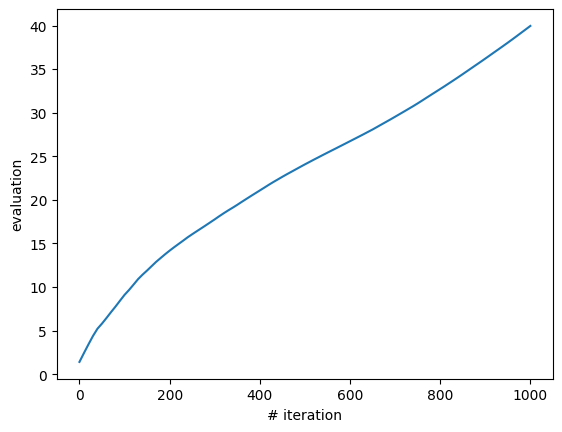

In [32]:
plt.plot(
    tracker_log["mei.objectives.EvaluationObjective"]["times"],
    tracker_log["mei.objectives.EvaluationObjective"]["values"],
)
plt.gca().set_xlabel("# iteration")
plt.gca().set_ylabel("evaluation")

# Constraints 
So far, we have not introduced contraints into MEI optimization. 
This results in implausible MEIs with high pixel values and high contrast and a forever increasing activation. We need to constrain the overall norm of the MEI and also clip the range of pixel values to the range of pixel values which were in the training data. 
The norm is then established empirically such, that ideally, value clipping is not necessary.

In [33]:
p = 2
norm_value = 10
max_pixel_value = 2.2606
min_pixel_value = -1.75047

method_config = dict(
    initial=dict(path="mei.initial.RandomNormal"),
    optimizer=dict(path="torch.optim.SGD", kwargs=dict(lr=lr)),
    stopper=dict(path="mei.stoppers.NumIterations", kwargs=dict(num_iterations=num_iterations)),
    objectives=[dict(path="mei.objectives.EvaluationObjective", kwargs=dict(interval=interval))],
    postprocessing=dict(path="mei.postprocessing.PNormConstraintAndClip", kwargs=dict(p=p, norm_value=norm_value, max_pixel_value=max_pixel_value, min_pixel_value=min_pixel_value)),
    device=device,
)

In [34]:
mei, final_evaluation, tracker_log = gradient_ascent(model=single_cell_model, config=method_config, seed=seed,
                                                     shape=input_shape)   

initial {'path': 'mei.initial.RandomNormal'}
optimizer {'path': 'torch.optim.SGD', 'kwargs': {'lr': 1}}
stopper {'path': 'mei.stoppers.NumIterations', 'kwargs': {'num_iterations': 1000}}
objectives [{'path': 'mei.objectives.EvaluationObjective', 'kwargs': {'interval': 10}}]
postprocessing {'path': 'mei.postprocessing.PNormConstraintAndClip', 'kwargs': {'p': 2, 'norm_value': 10, 'max_pixel_value': 2.2606, 'min_pixel_value': -1.75047}}
device cpu


torch.Size([1, 1, 100, 100])
tensor(2.0166)


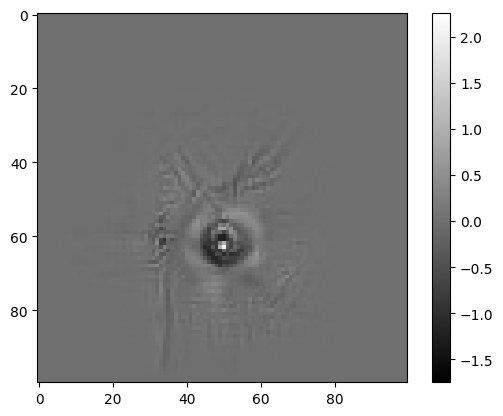

In [35]:
print(mei.shape)
max_value = torch.max(torch.abs(mei))
print(max_value)
plt.imshow(mei[0,0], cmap='gray', vmin=min_pixel_value, vmax=max_pixel_value)
plt.colorbar()
plt.show()


Text(0, 0.5, 'evaluation')

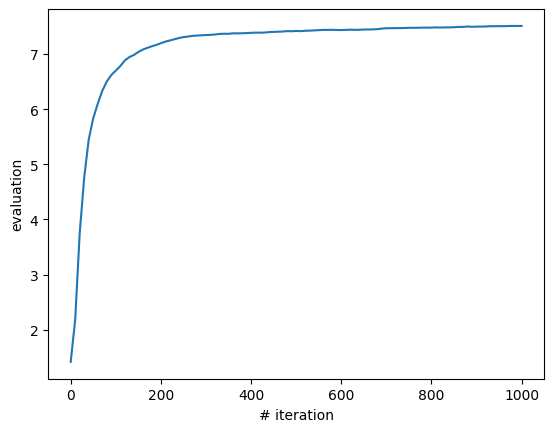

In [36]:
plt.plot(
    tracker_log["mei.objectives.EvaluationObjective"]["times"],
    tracker_log["mei.objectives.EvaluationObjective"]["values"],
)
plt.gca().set_xlabel("# iteration")
plt.gca().set_ylabel("evaluation")